# SELETON ONLY
Remove this block when this exercise has been fleshed out

# Exercise: Gradient Descent

We've discussed the basics of gradient descent, and we know there are multiple variations of this. Here, we will work with batch gradient descent and explore how changing the learning rate can alter its behaviour.

The model we will be working with will be a simple linear regression model - fitting a line to data. The principles we learn, however, apply to much more complex models too.

## Loading data and preparing our model

We will work with weather data we have seen in previous models. Our goal is to be able to predict the minimum daily temperature during the first half of the year.

Let's load our data and restrict it to the first six months of the year

Index(['date', 'amount_of_precipitation', 'max_temperature', 'min_temperature',
       'rain', 'day_of_year'],
      dtype='object')


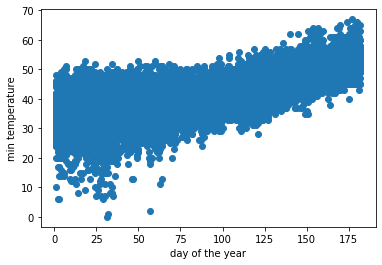

In [1]:
import pandas
from datetime import datetime

# Read the text file containing data using pandas
dataset = pandas.read_csv('seattleWeather_1948-2017.csv', parse_dates=['date'])

# Convert dates into day of the year
dataset['day_of_year'] = dataset.date.dt.dayofyear

# Only keep the first half of the year
dataset = dataset[dataset.day_of_year <= 182]

# delete unwanted columns
print(dataset.columns)
del dataset["amount_of_precipitation"]
del dataset["max_temperature"]
del dataset["rain"]

# Load matplotlib to create our graphs
import matplotlib.pyplot as graph

# Show a graph of min temperature by day of the year:
# -- This first line is a special command that lets this work in Jupyter Notebooks
%matplotlib inline
# -- Create a scatter plot
graph.scatter(dataset.day_of_year, dataset.min_temperature)
# -- Add some labels
graph.ylabel('min temperature')
graph.xlabel("day of the year")
# -- Show
graph.show()

## Fitting a model automatically

We already know we can fit a line to this data well using existing libraries. Let's do that now.

In [2]:
import statsmodels.formula.api as smf

# TODO - print better info

# Perform linear regression to fit a line to our data
model = smf.ols(formula = "min_temperature ~ day_of_year", data = dataset).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        min_temperature   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                 1.405e+04
Date:                Sun, 11 Apr 2021   Prob (F-statistic):               0.00
Time:                        23:29:13   Log-Likelihood:                -39663.
No. Observations:               12740   AIC:                         7.933e+04
Df Residuals:                   12738   BIC:                         7.934e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      31.8142      0.097    328.483      

We know how the 'best' line to fit this data, but how did the library calculate this? 

## Fitting our model with gradient descent

Let's replicate this line fitting, and break down each step so we can watch it in action.

Recall that for each iteration, our training conducts three steps: 

1) Estimation of y from x

2) Calculating the cost function and its slope

3) Adjusting our model according to this slope

Let's implement this now, to watch it in action. 

First, lets look at the error function for this data. Normally we don't know this in advance, but for learning purposes, we can calculate it now for different potential models

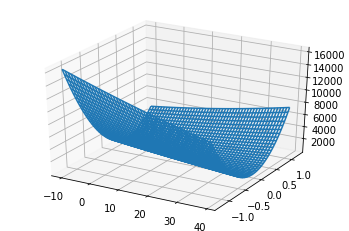

[[16365.42412186 15431.6843956  14525.77591935 ...  2565.23823783
   2939.56726158  3341.72753532]
 [16199.7775363  15270.61281005 14369.27933379 ...  2614.61665228
   2993.52067602  3400.25594976]
 [16035.13095075 15110.54122449 14213.78274823 ...  2664.99506672
   3048.47409046  3459.78436421]
 ...
 [ 9661.03460067  8942.31987441  8251.43639816 ...  5967.02371664
   6556.37774038  7173.56301413]
 [ 9542.38801511  8828.24828885  8141.9398126  ...  6063.40213108
   6657.33115483  7279.09142857]
 [ 9424.74142955  8715.1767033   8033.44322704 ...  6160.78054553
   6759.28456927  7385.61984301]]


In [3]:
import numpy as np
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
x = dataset.day_of_year
y_true = dataset.min_temperature


# Our cost function can be the sum of squared differences
def cost_function(y_estimate):
    """
    Our cost function is the mean squared error divided by 2
    """
    # Note that with numpy to square each value we use **
    ssd = np.sum((y_true - y_estimate) ** 2) / (2*len(y_estimate))
    return ssd


# TODO - this is horrible code that needs tidying
intercepts = []
slopes = []
errors = []
for intercept in range(-10,40):
    for slope in range(-25,25):
        slope = slope / 20 # TODO range doesn't support floats so we have this horror
        error = cost_function(slope * x + intercept)
        intercepts.append(intercept)
        slopes.append(slope)
        errors.append(error)
intercepts = np.array(intercepts).reshape((50,50))
slopes = np.array(slopes).reshape((50,50))
errors = np.array(errors).reshape((50,50))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# TODO add axis labels - this shows parameters vs the error we will hit
ax.plot_wireframe(intercepts, slopes, errors)

plt.show()

print(errors)

Notice how the curve above is a 2D surface - it changes with both intercept and with line slope. This means that its gradient must be described by two numbers - one for intercept, and one for line slope.
 
Our lowest point on the graph is with a slope of 0.109 and intercept of 31.8. Let's try to train a model to find this point

First we need a method that can calculate the gradient of the above curve. 

In [4]:
def calculate_gradient(y_estimate):
    """
    Our cost function is the sum of squared differences
    ssd = sum((predicted - actual)^2)
    """

    # The partial derivatives of MSE/2 are as follows
    # You don't need to be able to do this just yet but
    # it is important to note these give you the two gradients
    # that we need to train our model
    # TODO - check math
    
    grad_intercept = np.sum((y_estimate - y_true)) / len(y_estimate)
    grad_slope = np.sum((y_estimate - y_true) * x) / len(y_estimate)
    
    return grad_intercept, grad_slope

Now we need a starting guess, and a loop that will update this guess with each iteration 

In [5]:
import numpy as np
import matplotlib.pyplot as graph

# TODO this is super rough and doesn't work yet

# Make a method that can perform gradient descent
def gradient_descent(calculate_gradient, learning_rate, number_of_iterations):
    """
    Performs gradient descent for a one-variable function. 

    calculate_gradient: A function to calculate the gradient
    learning_rate: Larger numbers follow the gradient more aggressively
    number_of_iterations: The maximum number of iterations to perform
    """
    estimated_intercept = 31
    estimated_slope = 0.1

    for i in range(number_of_iterations):
        # Calculate the predicted values
        predicted_y = estimated_slope * x + estimated_intercept

        # Calculate the gradient
        grad_intercept, grad_slope = calculate_gradient(predicted_y)

        # Update the estimation of the line
        estimated_intercept = estimated_intercept - learning_rate * grad_intercept 
        estimated_slope = estimated_slope + learning_rate * grad_slope

        # Yield return the current estimation
        print(f"Current model is y={estimated_slope}x + {estimated_intercept}")


# Run it in a loop
learning_rate = 0.1
gradient_descent(calculate_gradient, learning_rate, 10)

Current model is y=-17.173202511773937x + 31.162158555729984
Current model is y=-19262.355350470956x + 189.3579042386185
Current model is y=-21461759.072640993x + 176425.15072917976
Current model is y=-23912151168.809258x + 196533882.3274799
Current model is y=-26642316155234.668x + 218973063692.87665
Current model is y=-2.968419717243785e+16x + 243974268577725.0
Current model is y=-3.3073384334831387e+19x + 2.7182998096952627e+17
Current model is y=-3.684953125076e+22x + 3.028661136465797e+20
Current model is y=-4.105681897121946e+25x + 3.3744579044673596e+23
Current model is y=-4.574447290969869e+28x + 3.759735947980601e+26


Our model found the correct answer, but it took a number of steps. Looking at the graph (TODO!) we can see how it progressively stepped toward the correct solution.

Now, what happens if we make the learning rate faster? This means taking larger steps

In [6]:
# TODO - demonstrate with a higher learning rate it finds the answer faster

It appears to have found the solution faset. If we increase the rate even faster, however, things don't go so well:

In [7]:
# TODO as above but with a uch higher learning rate. 

As we can see, the model became unstable - it did not manage to find the correct solution. 

This is because the steps it was taking were too large. While it would step towards the correct solution, it would step too far and actually get worse with each attempt.

For each model, there is an ideal learning rate. This is something that requires experimentation.

## Summary

Well done! In this unit we have:

1) watched gradient descent in action

2) seen how changing the learning rate can improve a model's training speed

3) learned that changing the learning rate can also result in unstable models 